__Домашнее задание к уроку №2__

1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

Сначала повторим код из урока:

In [ ]:
import pandas as pd

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

--2022-03-28 09:06:07--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 142.250.136.100, 142.250.136.102, 142.250.136.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.136.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lodqgrlvacnmnvqqe2mu5nfhdpsrea2l/1648458300000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download [following]
--2022-03-28 09:06:07--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lodqgrlvacnmnvqqe2mu5nfhdpsrea2l/1648458300000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-

In [ ]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2022-03-28 09:06:11--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 108.177.111.138, 108.177.111.102, 108.177.111.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.111.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/613b01kin5jk5253eug6lfp2o106c14d/1648458300000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download [following]
--2022-03-28 09:06:12--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/613b01kin5jk5253eug6lfp2o106c14d/1648458300000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
!pip install razdel pymorphy2 pyLDAvis

     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 1.7 MB 5.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 26.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1b4aab64ca0f880b54b796ac82a6411e872ef0f41e37ebf166494fe4863ab01a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2022-03-28 09:06:42--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 142.251.120.102, 142.251.120.139, 142.251.120.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.120.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o1n3u71rtadfimdgajuvdifm8vogf0v0/1648458375000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download [following]
--2022-03-28 09:06:42--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o1n3u71rtadfimdgajuvdifm8vogf0v0/1648458375000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0

In [ ]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Possible nested set at position 39
  


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [ ]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста.
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████| 27000/27000 [00:39<00:00, 683.86it/s] 

CPU times: user 31.6 s, sys: 1.88 s, total: 33.5 s
Wall time: 39.5 s


In [ ]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [04:52<00:00, 92.45it/s] 

CPU times: user 4min 36s, sys: 2.12 s, total: 4min 38s
Wall time: 4min 52s


In [ ]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение:

In [ ]:
N_topic = 25

In [ ]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 52.3 s, sys: 25.5 s, total: 1min 17s
Wall time: 49.4 s


In [ ]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [ ]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [ ]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.14852296),
 (8, 0.6888398),
 (14, 0.06106972),
 (19, 0.04326288),
 (23, 0.038304687)]

In [ ]:
x = lda.show_topics(num_topics=N_topic, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: ребёнок гражданин погибнуть операция тыс банк газета фронт народный иск
topic_1: журнал жизнь научный мозг статья опубликовать профессор ветер затмение жить
topic_2: млрд рост руб рынок проект развитие доллар банк открытие новый
topic_3: ракета орбита запуск американский двигатель испытание ядерный северный блок пуск
topic_4: россия новый проект цена российский наука рост уровень риск станция
topic_5: всё взрыв автор очень век большой ru форум армия первый
topic_6: научный учёный клетка заболевание болезнь поверхность врач выяснить солнечный возраст
topic_7: спутник центр обнаружить пострадать помощь произойти здание москва восток пассажир
topic_8: британский великобритания офицер выдать звезда бомба собака планета университет scie
topic_9: система сша правительство нефть министр регион российский газета добыча технология
topic_10: нефть поставка самолёт газпром ес производство россия сирия баррель режим
topic_11: учёный земля турист самолёт данные рак источник авиакомпания ро

In [ ]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 41.7 s, sys: 23.6 s, total: 1min 5s
Wall time: 43.4 s


In [ ]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.098336,0.0,0.100719,0.000000,0.0,0.000000,0.207869,...,0.0,0.037703,0.0,0.000000,0.000000,0.238895,0.0,0.239333,0.000000,0.070829
1,4896,0.0,0.0,0.000000,0.0,0.000000,0.866345,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.0,0.000000,0.0,0.000000,0.148558,0.0,0.000000,0.688805,...,0.0,0.000000,0.0,0.000000,0.043265,0.000000,0.0,0.000000,0.038306,0.000000
3,4898,0.0,0.0,0.000000,0.0,0.233994,0.581111,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.174164,0.0,0.000000,0.000000,0.000000
4,4899,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.106866,0.000000,...,0.0,0.000000,0.0,0.124028,0.000000,0.000000,0.0,0.270983,0.000000,0.000000


Векторное представление пользователей.

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [ ]:
doc_dict[293672]

array([0.        , 0.        , 0.3405357 , 0.        , 0.37605849,
       0.05714015, 0.        , 0.13022125, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04088239, 0.        , 0.        ,
       0.        , 0.        , 0.03996205, 0.        , 0.        ])

Скорректируем из урока функцию, теперь она считает медиану по вектору пользователя.

In [ ]:
def get_user_embedding_med(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # Медиана
    return user_vector

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_med(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 728 ms, sys: 14.8 ms, total: 743 ms
Wall time: 744 ms


In [ ]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.025895,0.0,0.034519,0.0,0.029848,0.089545,0.005927,0.061790,0.009574,...,0.0,0.000000,0.070930,0.000000,0.0,0.000000,0.000000,0.059770,0.0,0.000000
1,u108690,0.005638,0.0,0.030183,0.0,0.040887,0.070436,0.000000,0.028434,0.000000,...,0.0,0.000000,0.071629,0.013795,0.0,0.007955,0.124531,0.105650,0.0,0.036871
2,u108339,0.035613,0.0,0.038650,0.0,0.045089,0.029393,0.023280,0.066277,0.000000,...,0.0,0.016711,0.000000,0.000000,0.0,0.071836,0.005255,0.196666,0.0,0.025158


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку.

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2022-03-28 10:14:02--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 172.253.119.139, 172.253.119.138, 172.253.119.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/55cd92rpo548s381ecuab20o7tbhh72p/1648462425000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [following]
--2022-03-28 10:14:02--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/55cd92rpo548s381ecuab20o7tbhh72p/1648462425000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-0k-c0-docs.googleusercontent.com (doc-0k-c0

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.025895,0.0,0.034519,0.0,0.029848,0.089545,0.005927,0.061790,0.009574,...,0.000000,0.070930,0.000000,0.0,0.000000,0.000000,0.059770,0.0,0.000000,0
1,u108690,0.005638,0.0,0.030183,0.0,0.040887,0.070436,0.000000,0.028434,0.000000,...,0.000000,0.071629,0.013795,0.0,0.007955,0.124531,0.105650,0.0,0.036871,1
2,u108339,0.035613,0.0,0.038650,0.0,0.045089,0.029393,0.023280,0.066277,0.000000,...,0.016711,0.000000,0.000000,0.0,0.071836,0.005255,0.196666,0.0,0.025158,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
# обучим модель
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1531521 , 0.02166807, 0.44571906, 0.26485674, 0.02973769,
       0.04003154, 0.12585008, 0.03125052, 0.11379524, 0.13726048])

In [ ]:
y_pred = logreg.predict(X_test)

### Рассчитаем Precision, Recall, F_score и ROC_AUC

In [ ]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

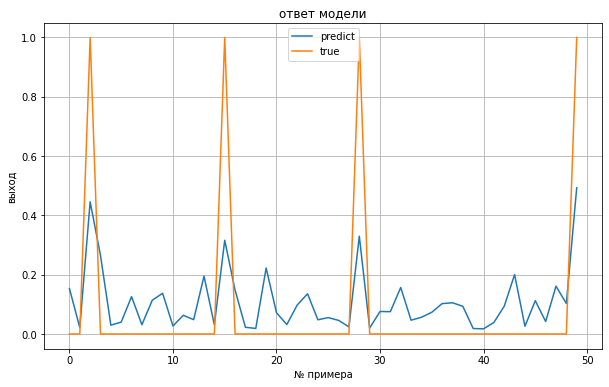

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')   
print('roc_auc_score =', roc_auc_score(y_test, y_pred))

Best Threshold=0.23998316873064496, F-Score=0.820, Precision=0.773, Recall=0.873
roc_auc_score= 0.7029420315134601


Сохраним данные для этого варианта модели:

In [ ]:
data_1 = [precision[ix], recall[ix], fscore[ix], roc_auc_score(y_test, y_pred)]
data_1

[0.7725631768953068,
 0.8734693877551021,
 0.8199233716475095,
 0.7029420315134601]

2. Повторить п.1, но используя уже не медиану, а max

Переделаем функцию для нахождения эмбендинга пользователя:

In [ ]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # максимум
    return user_vector

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 421 ms, sys: 11.3 ms, total: 432 ms
Wall time: 441 ms


Теперь получим эмбединги для всех пользователей.

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 381 ms, sys: 7.12 ms, total: 388 ms
Wall time: 395 ms


In [ ]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.190016,0.225569,0.340536,0.00000,0.376058,0.305417,0.156371,0.220806,0.117601,...,0.000000,0.066394,0.485764,0.000000,0.048836,0.042759,0.052740,0.269016,0.444754,0.190122
1,u108690,0.175256,0.048450,0.066932,0.02835,0.074639,0.086465,0.142558,0.173839,0.000000,...,0.043898,0.047301,0.223304,0.143349,0.054361,0.215978,0.380493,0.287527,0.023866,0.120699
2,u108339,0.117913,0.025351,0.119417,0.00000,0.058887,0.046051,0.089739,0.424180,0.018921,...,0.088228,0.088615,0.047023,0.034111,0.033372,0.161416,0.182969,0.316903,0.021534,0.100647


Переобучим модель:

In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.190016,0.225569,0.340536,0.00000,0.376058,0.305417,0.156371,0.220806,0.117601,...,0.066394,0.485764,0.000000,0.048836,0.042759,0.052740,0.269016,0.444754,0.190122,0
1,u108690,0.175256,0.048450,0.066932,0.02835,0.074639,0.086465,0.142558,0.173839,0.000000,...,0.047301,0.223304,0.143349,0.054361,0.215978,0.380493,0.287527,0.023866,0.120699,1
2,u108339,0.117913,0.025351,0.119417,0.00000,0.058887,0.046051,0.089739,0.424180,0.018921,...,0.088615,0.047023,0.034111,0.033372,0.161416,0.182969,0.316903,0.021534,0.100647,1


In [ ]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
# обучим модель
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)

### Рассчитаем Precision, Recall, F_score и ROC_AUC

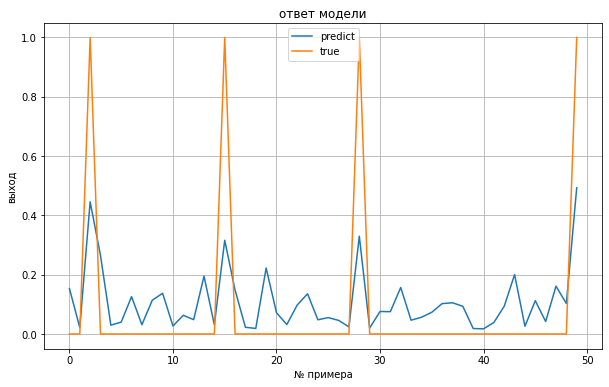

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')   
print('roc_auc_score =', roc_auc_score(y_test, y_pred))

Best Threshold=0.23998316873064496, F-Score=0.820, Precision=0.773, Recall=0.873
roc_auc_score = 0.822018722018722


Сохраним данные для этого варианта модели:

In [ ]:
data_2 = [precision[ix], recall[ix], fscore[ix], roc_auc_score(y_test, y_pred)]
data_2

[0.7725631768953068, 0.8734693877551021, 0.8199233716475095, 0.822018722018722]

 А также возьмем данные из урока для варианта с mean:

In [ ]:
data_3 = [0.55, 0.812, 0.656, 0.931]

3. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

In [ ]:
result_table = pd.DataFrame([data_1, data_2, data_3], index = ['median', 'max', 'mean'], columns = ['precision', 'recall', 'fscore', 'roc_auc'])
result_table

,precision,recall,fscore,roc_auc
median,0.772563,0.873469,0.819923,0.702942
max,0.772563,0.873469,0.819923,0.822019
mean,0.550000,0.812000,0.656000,0.931000


Выводы: если брать всю совокупность метрик, то лучше всего себя показал эмбендинг пользователей с помощью выбора максимальных значений тем, а хуже всего - с помощью выбора средних значений для тем.

По-моему, это происходит из-за того, что при усреднении значений тем сглаживаются те самые маркеры, по которым алгоритм ориентируется при классификации. Так как выборка неравномерна, точность модели повышается при увеличении "весов" тем.